In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pyod.models.knn import KNN
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer

## Load dataset

In [66]:
df = pd.read_csv('churn_data.csv', 
index_col = 'customerID')
df.head()

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,
7590-VHVEG,1,No,Month-to-month,Electronic check,29.85,29.85,No
5575-GNVDE,34,Yes,One year,Mailed check,56.95,1889.50,No
3668-QPYBK,2,Yes,Month-to-month,Mailed check,53.85,108.15,Yes
7795-CFOCW,45,No,One year,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,2,Yes,Month-to-month,Electronic check,70.70,151.65,Yes


## Check for outliers

<Axes: >

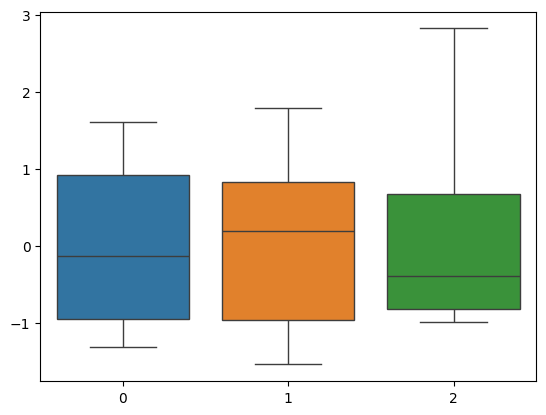

In [67]:
df_copy = df.copy()
numeric_df = df_copy.select_dtypes(exclude=['object'])

scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(numeric_df)

# scaled_numeric

sns.boxplot(data = scaled_numeric)

In [68]:

for column in numeric_df:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    upper_boundary = q3 + 1.5 * iqr
    lower_boundary = q1 - 1.5 * iqr
    outliers = df[(df[column] < lower_boundary) | (df[column] > upper_boundary)][column]
    if outliers.shape[0] > 0:
        print(outliers)
    else:
        print(f'no outliers for {column}')

no outliers for tenure
no outliers for MonthlyCharges
no outliers for TotalCharges


## Check for MIssing values

In [69]:
df.isna().sum()

tenure             0
PhoneService       0
Contract           0
PaymentMethod      0
MonthlyCharges     0
TotalCharges      11
Churn              0
dtype: int64

## Fill missing values

In [70]:

df.fillna(df['TotalCharges'].median(), inplace=True)

## Convert Categorical columns to numeric

In [71]:
df['PhoneService'] = df['PhoneService'].replace({'No': 0, 'Yes': 1})
df['PhoneService'].value_counts()

PhoneService
1    6361
0     682
Name: count, dtype: int64

In [72]:
df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})
df['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [73]:
df['PaymentMethod'] = df['PaymentMethod'].replace({'Electronic check': 3,'Mailed check': 2,'Bank transfer (automatic)': 1,'Credit card (automatic)': 0})
df['PaymentMethod'].value_counts()

PaymentMethod
3    2365
2    1612
1    1544
0    1522
Name: count, dtype: int64

## Get dummies

In [74]:
Contract_dummies = pd.get_dummies(df['Contract'], prefix='Contract')

df = pd.concat([df, Contract_dummies], axis=1)
df.head()

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Contract_Month-to-month,Contract_One year,Contract_Two year
customerID,,,,,,,,,,
7590-VHVEG,1,0,Month-to-month,3,29.85,29.85,0,True,False,False
5575-GNVDE,34,1,One year,2,56.95,1889.50,0,False,True,False
3668-QPYBK,2,1,Month-to-month,2,53.85,108.15,1,True,False,False
7795-CFOCW,45,0,One year,1,42.30,1840.75,0,False,True,False
9237-HQITU,2,1,Month-to-month,3,70.70,151.65,1,True,False,False


In [75]:
dummies = ['Contract_Month-to-month', 'Contract_One year', 'Contract_Two year']

for column in dummies:
    df[column] = pd.factorize(df[column])[0]

df.sample(5)

,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Contract_Month-to-month,Contract_One year,Contract_Two year
customerID,,,,,,,,,,
6366-ZGQGL,1,0,Month-to-month,1,24.80,24.80,1,0,0,0
2979-SXESE,17,1,Month-to-month,3,94.40,1607.20,1,0,0,0
8784-CGILN,18,1,Month-to-month,1,99.85,1776.95,1,0,0,0
0278-YXOOG,5,1,Month-to-month,2,21.05,113.85,1,0,0,0
7658-UYUQS,21,1,Month-to-month,1,86.55,1857.25,0,0,0,0


In [76]:
df = df.drop([ 'Contract'], axis=1)
df

,tenure,PhoneService,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Contract_Month-to-month,Contract_One year,Contract_Two year
customerID,,,,,,,,,
7590-VHVEG,1,0,3,29.85,29.85,0,0,0,0
5575-GNVDE,34,1,2,56.95,1889.50,0,1,1,0
3668-QPYBK,2,1,2,53.85,108.15,1,0,0,0
7795-CFOCW,45,0,1,42.30,1840.75,0,1,1,0
9237-HQITU,2,1,3,70.70,151.65,1,0,0,0
...,...,...,...,...,...,...,...,...,...
6840-RESVB,24,1,2,84.80,1990.50,0,1,1,0
2234-XADUH,72,1,0,103.20,7362.90,0,1,1,0
4801-JZAZL,11,0,3,29.60,346.45,0,0,0,0


## Feature Engineering

In [77]:
df[df['tenure'] == 0]

,tenure,PhoneService,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Contract_Month-to-month,Contract_One year,Contract_Two year
customerID,,,,,,,,,
4472-LVYGI,0,0,1,52.55,1397.475,0,1,0,1
3115-CZMZD,0,1,2,20.25,1397.475,0,1,0,1
5709-LVOEQ,0,1,2,80.85,1397.475,0,1,0,1
4367-NUYAO,0,1,2,25.75,1397.475,0,1,0,1
1371-DWPAZ,0,0,0,56.05,1397.475,0,1,0,1
7644-OMVMY,0,1,2,19.85,1397.475,0,1,0,1
3213-VVOLG,0,1,2,25.35,1397.475,0,1,0,1
2520-SGTTA,0,1,2,20.00,1397.475,0,1,0,1
2923-ARZLG,0,1,2,19.70,1397.475,0,1,1,0


In [78]:
# Replace 0 tenure with NaN adn fill with median tenure
df.loc[df['tenure'] == 0, 'tenure'] = np.nan
df['tenure'].fillna(df['tenure'].median(), inplace=True)

In [79]:
df['TotalCharges_Tenure_Ratio'] = df['TotalCharges'] / df['tenure']

In [80]:
df['MonthlyCharges_Tenure_Ratio'] = df['MonthlyCharges'] / df['tenure']

## Histograms

<Axes: xlabel='TotalCharges_Tenure_Ratio', ylabel='Count'>

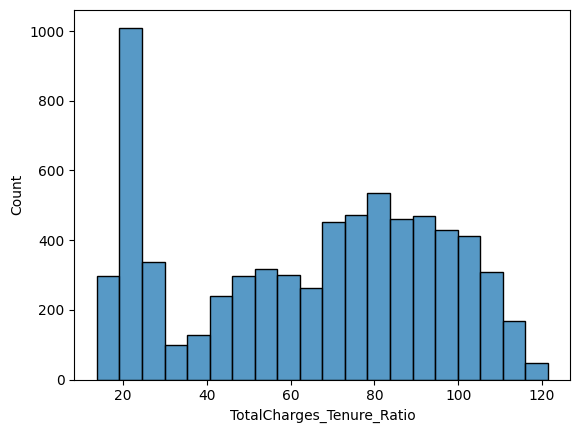

In [81]:
sns.histplot(data=df, x='TotalCharges_Tenure_Ratio')

<Axes: xlabel='MonthlyCharges_Tenure_Ratio', ylabel='Count'>

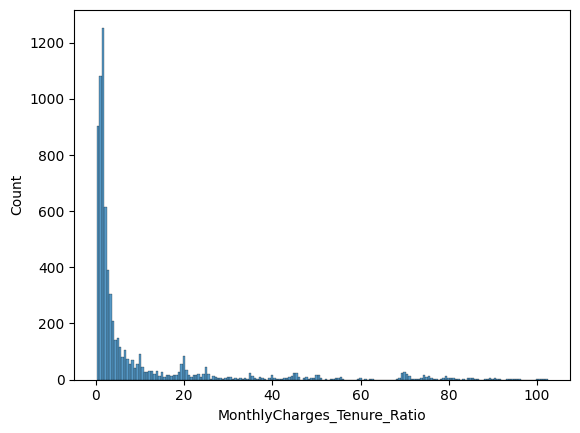

In [82]:
sns.histplot(data=df, x='MonthlyCharges_Tenure_Ratio')

In [83]:
df.isna().sum()

tenure                         0
PhoneService                   0
PaymentMethod                  0
MonthlyCharges                 0
TotalCharges                   0
Churn                          0
Contract_Month-to-month        0
Contract_One year              0
Contract_Two year              0
TotalCharges_Tenure_Ratio      0
MonthlyCharges_Tenure_Ratio    0
dtype: int64

In [85]:
df.to_csv('preprocessed_churn_data.csv')

## Summary

We conduct analysis of the customer churn dataset. A boxplot is generated to visualize the distribution of numeric columns, identifying potential outliers. We handle outliers by clipping values based on the interquartile range. Missing values in the TotalCharges column are addressed by dropping corresponding entries. Categorical-to-numeric conversion is performed for the Churn, 'PaymentMethod', and 'PhoneService' columns. Feature engineering includes creating new features, TotalCharges_Tenure_Ratio and Monthly_Tenure_Ratio. During this process, we identify tenure values of 0 as missing values, replacing them with NaN and filling them with the median value before creating the new feature. Finally, the prepped data is saved in a CSV file named preprocessed_churn_data, ready for further analysis.
